In [48]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
import json
import pickle
import os
import sys
from tqdm import tqdm
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import prophet
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from functools import partial
from sklearn.metrics import mean_squared_error as mse, \
                            mean_absolute_error as mae, \
                            r2_score as r2
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm import tqdm
import time
import gc

In [49]:
def discriminador(row):
    mean = np.mean(row)
    std = np.std(row)
    threshold = 3 * std
    outlier = np.abs(row - mean) > threshold
    return outlier


In [50]:
normalizacion = True

root_path = "/home/upo/Desktop/Test_FVPredictive/FVPredictive_TEST/Galisteo"
params = None
for filename in os.listdir(root_path):
    if "params.json" in filename:
        with open(os.path.join(root_path, filename)) as f:
            params = json.load(f)
if params is None:
    print("No se ha encontrado el archivo de parámetros para la conexión a la base de datos")
    sys.exit()
data_path = os.path.join(root_path, params["data_path"])
schema_name = params["schema"]

password = params['password'].replace('@', '%40')
engine = create_engine(f'postgresql://{params["user"]}:{password}@{params["host"]}:{params["port"]}/{params["dbname"]}')
print(f"Conexión a la base de datos {params['dbname']} (esquema {schema_name}) establecida")

Conexión a la base de datos fvpredictive (esquema galisteo) establecida


In [51]:
intervalo_min = 30
num_mod_string = 30
sup_mod = 2
# Carga de los datos de entrenamiento
main_query = f"""
            WITH inv AS (
                SELECT 
                    date_trunc('hour', datetime_utc) + 
                    INTERVAL '{intervalo_min} min' * floor(date_part('minute', datetime_utc) / {intervalo_min}) as datetime_utc_rounded,
                    dispositivo_id,
                    MIN(inv.id) AS id, 
                    AVG(potencia_act) as potencia_act, 
                    AVG(amp_dc) as amp_dc,
                    det.entrada_id
                FROM {schema_name}.inversores AS inv
                JOIN {schema_name}.inversores_detalle AS det
                    ON inv.id = det.id
                WHERE (dispositivo_id != 26)
                    AND (alarma = 0)
                    AND (estado = 6)
                GROUP BY datetime_utc_rounded, dispositivo_id, det.entrada_id 
            ),
            met AS (
                SELECT 
                    date_trunc('hour', datetime_utc) + 
                    INTERVAL '{intervalo_min} min' * floor(date_part('minute', datetime_utc) / {intervalo_min}) as datetime_utc_rounded, 
                    dispositivo_id,
                    AVG(rad_poa) AS rad_poa, 
                    AVG(rad_hor) AS rad_hor, 
                    AVG(rad_celda1) AS rad_celda1,
                    AVG(rad_celda2) AS rad_celda2, 
                    AVG(temp_amb) AS temp_amb, 
                    AVG(temp_panel1) AS temp_panel1,
                    AVG(temp_panel2) AS temp_panel2, 
                    AVG(cloud_impact) AS cloud_impact,
                    BOOL_OR(daylight) AS daylight
                FROM {schema_name}.meteo
                    WHERE daylight = true
                GROUP BY dispositivo_id, datetime_utc_rounded
            )
            SELECT 
                inv.id,
                inv.dispositivo_id,
                inv.entrada_id,
                inv.datetime_utc_rounded as datetime_utc, 
                potencia_act,  
                num_strings, 
                rad_poa,
                rad_hor, 
                rad_celda1, 
                rad_celda2, 
                temp_amb, 
                temp_panel1, 
                temp_panel2,
                cloud_impact,
                motivo,
                consigna_pot_act_planta,
                amp_dc
            FROM inv
            JOIN {schema_name}.distrib_inversores dist
                ON dist.dispositivo_id = inv.dispositivo_id
                    AND dist.entrada_id = inv.entrada_id
            JOIN {schema_name}.dispositivos AS disp
                ON disp.dispositivo_id = inv.dispositivo_id
            JOIN met
                ON met.datetime_utc_rounded = inv.datetime_utc_rounded
                    AND met.dispositivo_id = disp.meteo_cercana_id
            JOIN {schema_name}.ree AS ree
                ON ree.datetime_utc = inv.datetime_utc_rounded
            ORDER BY 5, 2, 3, 4;"""
chunksize = 100000
chunks = pd.read_sql_query(main_query, engine, chunksize=chunksize)
main_df = pd.DataFrame()
for chunk in chunks:
    main_df = pd.concat([main_df, chunk], ignore_index = True)

In [52]:
# Normalización de la entrada de corriente continua, formateo de fechas y escalado de potencia
print(f"Carga inicial de {main_df.shape[0]} registros")
if normalizacion:
    print("Entrada de corriente continua normalizada según el número de strings")
    main_df["amp_dc"] = main_df["amp_dc"]/main_df["num_strings"]
else:
    print("Entrada de corriente continua sin normalizar")
main_df["datetime_utc"] = pd.to_datetime(main_df["datetime_utc"], utc = True)
main_df["potencia_act"] = main_df["potencia_act"] * 1000

Carga inicial de 2397040 registros
Entrada de corriente continua normalizada según el número de strings


In [53]:
main_df

,id,dispositivo_id,entrada_id,datetime_utc,potencia_act,num_strings,rad_poa,rad_hor,rad_celda1,rad_celda2,temp_amb,temp_panel1,temp_panel2,cloud_impact,motivo,consigna_pot_act_planta,amp_dc
0,3329739,24,1,2023-06-29 05:00:00+00:00,-1.600000e+04,24,23.631667,20.818333,24.118333,23.506667,19.136667,17.655,16.613333,100.000000,0,38.7,0.016667
1,3329739,24,2,2023-06-29 05:00:00+00:00,-1.600000e+04,24,23.631667,20.818333,24.118333,23.506667,19.136667,17.655,16.613333,100.000000,0,38.7,-0.008333
2,3329739,24,3,2023-06-29 05:00:00+00:00,-1.600000e+04,21,23.631667,20.818333,24.118333,23.506667,19.136667,17.655,16.613333,100.000000,0,38.7,0.019048
3,3329739,24,4,2023-06-29 05:00:00+00:00,-1.600000e+04,24,23.631667,20.818333,24.118333,23.506667,19.136667,17.655,16.613333,100.000000,0,38.7,0.104167
4,3329739,24,5,2023-06-29 05:00:00+00:00,-1.600000e+04,24,23.631667,20.818333,24.118333,23.506667,19.136667,17.655,16.613333,100.000000,0,38.7,0.104167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2397035,10864804,32,12,2022-04-19 11:00:00+00:00,3.567183e+06,24,1149.805001,1111.385004,1118.278336,1105.185003,22.110000,34.135,30.863333,83.421234,0,38.7,8.026111
2397036,10864804,32,13,2022-04-19 11:00:00+00:00,3.567183e+06,24,1149.805001,1111.385004,1118.278336,1105.185003,22.110000,34.135,30.863333,83.421234,0,38.7,7.864653
2397037,10864804,32,14,2022-04-19 11:00:00+00:00,3.567183e+06,24,1149.805001,1111.385004,1118.278336,1105.185003,22.110000,34.135,30.863333,83.421234,0,38.7,7.925486
2397038,10864804,32,15,2022-04-19 11:00:00+00:00,3.567183e+06,24,1149.805001,1111.385004,1118.278336,1105.185003,22.110000,34.135,30.863333,83.421234,0,38.7,7.974792


In [54]:
# Pivotado de las entradas de corriente continua
target_df = main_df.pivot(index=["dispositivo_id", "datetime_utc"], columns='entrada_id', values='amp_dc')
target_df.columns = ["amp_dc_" + str(col) for col in target_df.columns]
print(f"Número de registros del dataframe tras pivotar: {target_df.shape[0]}")

Número de registros del dataframe tras pivotar: 149815


In [55]:
target_df

amp_dc_1  amp_dc_2  amp_dc_3  \
dispositivo_id datetime_utc                                              
21             2022-01-01 08:00:00+00:00  0.297270  0.428089  0.443534   
               2022-01-01 08:30:00+00:00  1.281875  1.438056  1.438472   
               2022-01-01 09:00:00+00:00  2.503194  2.650208  2.634236   
               2022-01-01 09:30:00+00:00  3.980347  4.111667  4.058056   
               2022-01-01 10:00:00+00:00  4.387778  4.446736  4.486806   
...                                            ...       ...       ...   
33             2023-09-30 16:00:00+00:00  5.908333  6.107569  6.172292   
               2023-09-30 16:30:00+00:00  3.704444  4.387431  4.354722   
               2023-09-30 17:00:00+00:00  1.735159  2.089375  2.006458   
               2023-09-30 17:30:00+00:00  0.304921  0.374931  0.414444   
               2023-09-30 18:00:00+00:00 -0.019048 -0.037500  0.025000   

                                          amp_dc_4  amp_dc_5  amp_dc_6  \
dispositivo_id datetime_utc                                              
21             2022-01-01 08:00:00+00:00  0.511853  0.466882  0.463003   
               2022-01-01 08:30:00+00:00  1.552708  1.425278  1.425556   
               2022-01-01 09:00:00+00:00  2.779722  2.542847  2.546111   
               2022-01-01 09:30:00+00:00  4.192986  3.861042  3.862917   
               2022-01-01 10:00:00+00:00  4.529653  4.240139  4.237569   
...                                            ...       ...       ...   
33             2023-09-30 16:00:00+00:00  6.216042  6.154306  6.062569   
               2023-09-30 16:30:00+00:00  4.374861  4.453056  4.216181   
               2023-09-30 17:00:00+00:00  2.072986  2.137361  2.028056   
               2023-09-30 17:30:00+00:00  0.483750  0.431806  0.407153   
               2023-09-30 18:00:00+00:00  0.075000  0.025000  0.025000   

                                          amp_dc_7  amp_dc_8  amp_dc_9  \
dispositivo_id datetime_utc                                              
21             2022-01-01 08:00:00+00:00  0.364614  0.466236  0.420279   
               2022-01-01 08:30:00+00:00  1.317302  1.510000  1.363016   
               2022-01-01 09:00:00+00:00  2.439603  2.748056  2.465873   
               2022-01-01 09:30:00+00:00  3.710238  4.193194  3.763730   
               2022-01-01 10:00:00+00:00  4.078413  4.543542  4.142302   
...                                            ...       ...       ...   
33             2023-09-30 16:00:00+00:00  6.140556  6.109097  5.973542   
               2023-09-30 16:30:00+00:00  4.253889  4.313056  4.087431   
               2023-09-30 17:00:00+00:00  1.955238  1.986875  1.810764   
               2023-09-30 17:30:00+00:00  0.422302  0.409375  0.335069   
               2023-09-30 18:00:00+00:00  0.042857  0.037500 -0.016667   

                                          amp_dc_10  amp_dc_11  amp_dc_12  \
dispositivo_id datetime_utc                                                 
21             2022-01-01 08:00:00+00:00   0.401149   0.322845   0.326365   
               2022-01-01 08:30:00+00:00   1.309097   1.190347   1.302639   
               2022-01-01 09:00:00+00:00   2.532014   2.394306   2.534028   
               2022-01-01 09:30:00+00:00   4.035764   3.848194   4.056250   
               2022-01-01 10:00:00+00:00   4.578194   4.442222   4.519167   
...                                             ...        ...        ...   
33             2023-09-30 16:00:00+00:00   5.911389   6.011319   6.269653   
               2023-09-30 16:30:00+00:00   3.824792   3.906806   4.513681   
               2023-09-30 17:00:00+00:00   1.775694   1.870278   2.160833   
               2023-09-30 17:30:00+00:00   0.341944   0.431806   0.544722   
               2023-09-30 18:00:00+00:00   0.016667   0.091667   0.170833   

                                          amp_dc_13  amp_dc_14  amp_dc_15  \
dispositivo_id datetime_utc                                               

In [56]:
# Descarte de registros con corriente anómala
target_df["outlier"] = target_df.apply(discriminador, axis=1).any(axis=1)
n_corriente_outlier = target_df[target_df["outlier"]].shape[0]
target_df = target_df[~target_df["outlier"]].drop(columns="outlier")
print(f"Registros descartados por corrientes anómalas ingresando en el inversor: {n_corriente_outlier}")

Registros descartados por corrientes anómalas ingresando en el inversor: 25125


In [57]:
# Rellenado de valores faltantes por desconexión de entradas
consulta_sql = f"""SELECT MAX(entrada_id)
            FROM {schema_name}.distrib_inversores;"""
max_entradas = pd.read_sql_query(consulta_sql, engine).values[0][0]
entradas = [i for i in range(1, max_entradas + 1)]
for dispositivo in target_df.index.get_level_values(0).unique():
    consulta_sql = f"""SELECT entrada_id
                FROM {schema_name}.distrib_inversores
                WHERE dispositivo_id = {dispositivo};"""
    entradas_inv = pd.read_sql_query(consulta_sql, engine).values.reshape(1,-1)[0]
    entradas_off = list(set(entradas) - set(entradas_inv))
    for entrada in entradas_off:
        target_df.loc[dispositivo, "amp_dc_" + str(entrada)] = 0

In [58]:
# Descarte de registros con corriente desconocida
n_nan_values = target_df[target_df.isna().any(axis=1)].shape[0]
target_df = target_df.dropna()
print(f"Registros descartados por corriente desconocida: {n_nan_values}")

Registros descartados por corriente desconocida: 0


In [59]:
# Descarte de registros con corriente negativa
q1 = main_df[main_df['amp_dc'] < 0]['amp_dc'].quantile(0.25)
q3 = main_df[main_df['amp_dc'] < 0]['amp_dc'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
n_corriente_neg = target_df[target_df < lower_bound].dropna(how='all').shape[0]
target_df = target_df[target_df >= lower_bound].dropna(how='any')
target_df[(target_df >= lower_bound) & (target_df <= 0)] = 0
main_df = main_df.drop(columns=["entrada_id", "amp_dc"]).drop_duplicates(subset=["id", "datetime_utc"]).set_index(["dispositivo_id", "datetime_utc"])
main_df = main_df.merge(target_df, left_index=True, right_index=True, how="inner")
del target_df
gc.collect()
print(f"Registros descartados por corriente negativa: {n_corriente_neg}")

Registros descartados por corriente negativa: 179


In [60]:
# Búsqueda de outliers basándose en la potencia activa y la potencia solar
num_strings_inv = f"""SELECT dispositivo_id, SUM(num_strings) as num_strings 
                        FROM {schema_name}.distrib_inversores
                        GROUP BY dispositivo_id;"""
num_strings_inv = pd.read_sql_query(num_strings_inv, engine).sort_values(by="dispositivo_id")
potencia_df = pd.merge(main_df.reset_index()[["dispositivo_id", "datetime_utc", "potencia_act", "rad_poa"]], num_strings_inv, on="dispositivo_id").set_index(["dispositivo_id", "datetime_utc"])
potencia_df["potencia_solar"] = potencia_df["rad_poa"] * potencia_df["num_strings"] * num_mod_string * sup_mod
potencia_df["outlier_solar"] = np.where(potencia_df["potencia_act"] > 0.20 * potencia_df["potencia_solar"], True, False)
main_df = main_df.merge(potencia_df[["outlier_solar"]], left_index=True, right_index=True, how="inner")
print(f"Registros descartados por outlier de potencia: {main_df[main_df['outlier_solar'] == True].shape[0]}")
main_df = main_df[main_df["outlier_solar"] == False].drop(columns = ["outlier_solar"])
del potencia_df, num_strings_inv
gc.collect()

Registros descartados por outlier de potencia: 1456


0

In [61]:
# Descarte de registros con potencia activa negativa
n_potencia_neg = main_df[main_df["potencia_act"] < 0].shape[0]
main_df = main_df[main_df["potencia_act"] >= 0]
print(f"Registros descartados por potencia activa negativa: {n_potencia_neg}")

Registros descartados por potencia activa negativa: 23


In [62]:
# Manipulación de variables meteorológicas
main_df["rad_diff"] = (main_df["rad_celda1"] - main_df["rad_celda2"])
main_df["temp_panel"] = (main_df["temp_panel1"] + main_df["temp_panel2"]) / 2
main_df = main_df.drop(columns = ["rad_celda1", "rad_celda2", "temp_panel1", "temp_panel2"])

In [63]:
# Manipulación de variables de consigna
main_df["motivo"] = main_df["motivo"].apply(lambda x: 0 if x == 0 else (2 if x == 7 else 1))
main_query = f"""
    SELECT MAX(consigna_pot_act_planta)
        FROM {schema_name}.ree AS ree;"""
max_pot_act = pd.read_sql_query(main_query, engine).values[0][0]
main_df["consigna_pot_act_planta"] = main_df["consigna_pot_act_planta"] / max_pot_act   # Valor normalizado

In [64]:
# Escalado de variables porcentuales
main_df[['cloud_impact']] = main_df[['cloud_impact']].apply(lambda x: x/100)

In [65]:
main_df

id  potencia_act  num_strings  \
dispositivo_id datetime_utc                                                     
22             2022-04-19 05:30:00+00:00  10856981  0.000000e+00           24   
               2022-09-02 05:30:00+00:00  15938061  0.000000e+00           24   
30             2022-05-16 05:30:00+00:00  11865379  0.000000e+00           24   
31             2023-09-02 17:00:00+00:00   5774864  0.000000e+00           24   
32             2023-04-18 05:30:00+00:00    635806  0.000000e+00           21   
...                                            ...           ...          ...   
31             2022-05-05 15:30:00+00:00  11469163  3.382000e+06           24   
               2022-05-05 16:30:00+00:00  11470723  3.382000e+06           24   
               2022-05-05 17:00:00+00:00  11471503  3.382000e+06           24   
               2023-06-20 11:30:00+00:00   3002606  3.384467e+06           24   
               2022-04-19 11:00:00+00:00  10864803  3.405000e+06           24   

                                              rad_poa      rad_hor   temp_amb  \
dispositivo_id datetime_utc                                                     
22             2022-04-19 05:30:00+00:00    15.182500    14.042500  13.005000   
               2022-09-02 05:30:00+00:00     5.400000     5.206667  12.833333   
30             2022-05-16 05:30:00+00:00    36.768333    35.041667  16.978333   
31             2023-09-02 17:00:00+00:00     9.600000     9.405000  18.071667   
32             2023-04-18 05:30:00+00:00    12.805405    10.737838  11.513514   
...                                               ...          ...        ...   
31             2022-05-05 15:30:00+00:00   834.148332   609.415001  35.823333   
               2022-05-05 16:30:00+00:00   898.473333   503.703330  35.983333   
               2022-05-05 17:00:00+00:00   801.754998   382.193334  35.565000   
               2023-06-20 11:30:00+00:00  1142.881665  1141.396661  23.480000   
               2022-04-19 11:00:00+00:00  1149.805001  1111.385004  22.110000   

                                          cloud_impact  motivo  \
dispositivo_id datetime_utc                                      
22             2022-04-19 05:30:00+00:00      1.000000       0   
               2022-09-02 05:30:00+00:00      1.000000       0   
30             2022-05-16 05:30:00+00:00      0.598913       0   
31             2023-09-02 17:00:00+00:00      0.011837       0   
32             2023-04-18 05:30:00+00:00      1.000000       0   
...                                                ...     ...   
31             2022-05-05 15:30:00+00:00      0.768110       0   
               2022-05-05 16:30:00+00:00      1.000000       0   
               2022-05-05 17:00:00+00:00      1.000000       0   
               2023-06-20 11:30:00+00:00      0.977627       2   
               2022-04-19 11:00:00+00:00      0.834212       0   

                                          consigna_pot_act_planta  amp_dc_1  \
dispositivo_id datetime_utc                                                   
22             2022-04-19 05:30:00+00:00                      1.0  0.000000   
               2022-09-02 05:30:00+00:00                      1.0  0.104167   
30             2022-05-16 05:30:00+00:00                      1.0  0.008333   
31             2023-09-02 17:00:00+00:00                      1.0  0.000000   
32             2023-04-18 05:30:00+00:00                      1.0  0.000000   
...                                                           ...       ...   
31             2022-05-05 15:30:00+00:00                      1.0  8.741667   
               2022-05-05 16:30:00+00:00                      1.0  8.741667   
               2022-05-05 17:00:00+00:00                      1.0  8.741667   
               2023-06-20 11:30:00+00:00                      1.0  8.233889   
               2022-04-19 11:00:00+00:00                      1.0  6.377847   

                                          ...  amp_dc

In [66]:
target_columns = main_df.filter(like="amp_dc").columns.tolist()
main_df = main_df.drop(columns = target_columns+["id", "num_strings", "motivo"])

In [72]:
inv_id = 21
print(f"Dispositivo {inv_id}")
disp_df = main_df[main_df.index.get_level_values("dispositivo_id") == inv_id].copy()
disp_df = disp_df.dropna()
#disp_100_df = disp_df[disp_df["consigna_pot_act_planta"] == 1]
disp_100_df = disp_df.droplevel(0)
disp_100_df.sort_index()

Dispositivo 21


,potencia_act,rad_poa,rad_hor,temp_amb,cloud_impact,consigna_pot_act_planta,rad_diff,temp_panel
datetime_utc,,,,,,,,
2022-01-01 08:00:00+00:00,1.326207e+05,69.521667,46.343333,6.510000,1.000000,1.0,5.380000,5.566667
2022-01-01 08:30:00+00:00,4.510333e+05,202.225000,106.390000,6.981667,0.972236,1.0,8.821667,7.248333
2022-01-01 09:00:00+00:00,8.440333e+05,339.986668,169.248333,7.648333,0.886993,1.0,6.173332,9.861667
2022-01-01 09:30:00+00:00,1.289383e+06,515.288334,248.694999,9.013333,0.985402,1.0,2.231660,15.255000
2022-01-01 10:00:00+00:00,1.386867e+06,563.458330,317.996668,11.086667,0.961432,1.0,0.976661,21.575000
...,...,...,...,...,...,...,...,...
2023-09-30 15:30:00+00:00,2.459167e+06,795.006664,397.788333,34.516667,1.000000,1.0,3.975006,49.553333
2023-09-30 16:00:00+00:00,2.269350e+06,726.560001,304.121667,34.298333,1.000000,1.0,3.866664,48.562500
2023-09-30 16:30:00+00:00,1.431583e+06,515.650001,207.036666,33.811667,1.000000,1.0,3.149996,44.305000


In [73]:
from sklearn.metrics import mean_squared_error as mse, \
                            mean_absolute_error as mae, \
                            r2_score as r2
from prophet import Prophet
from sklearn.preprocessing import StandardScaler

# Normalize the covariates
scaler = StandardScaler()
covariates = ['rad_poa', 'rad_hor', 'temp_amb', 'rad_diff', 'temp_panel']
disp_100_df[covariates] = scaler.fit_transform(disp_100_df[covariates])

model = Prophet()
model.add_regressor('rad_poa')
model.add_regressor('rad_hor')
model.add_regressor('temp_amb')
model.add_regressor('cloud_impact')
model.add_regressor('consigna_pot_act_planta')
model.add_regressor('rad_diff')
model.add_regressor('temp_panel')


disp_100_df = disp_100_df.reset_index().rename(columns={"datetime_utc": "ds", "potencia_act": "y"})
disp_100_df["ds"] = disp_100_df["ds"].dt.tz_convert(None)
# Train and validate the Prophet model
train_size = int(len(disp_100_df) * 0.8)  # 80% of the data for training
train_df = disp_100_df[:train_size]
test_df = disp_100_df[train_size:]

# Fit the model on the training data
model.fit(train_df)

# Make predictions on the test data
forecast = model.predict(test_df)

# Calculate RMSE
rmse = np.sqrt(mse(test_df['y'], forecast['yhat']))

# Print the RMSE
print(f"RMSE: {rmse}")


13:29:54 - cmdstanpy - INFO - Chain [1] start processing
13:29:56 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 221114.85091919167


In [69]:
model.predict(test_df).merge(test_df[['ds','y']], on= "ds")

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,cloud_impact,...,temp_panel_lower,temp_panel_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
0,2022-02-20 09:30:00,1.708641e+06,2.447723e+06,2.889980e+06,1.708641e+06,1.708641e+06,9.553561e+05,9.553561e+05,9.553561e+05,6032.015762,...,24082.491126,24082.491126,1280.477216,1280.477216,1280.477216,0.0,0.0,0.0,2.663997e+06,2.746617e+06
1,2022-02-22 09:30:00,1.709544e+06,2.505806e+06,2.966179e+06,1.709544e+06,1.709544e+06,1.029662e+06,1.029662e+06,1.029662e+06,6032.015762,...,12378.584763,12378.584763,6475.909276,6475.909276,6475.909276,0.0,0.0,0.0,2.739206e+06,2.813600e+06
2,2022-03-02 10:00:00,1.713166e+06,2.453143e+06,2.908592e+06,1.713166e+06,1.713166e+06,9.727052e+05,9.727052e+05,9.727052e+05,6032.015762,...,7047.672288,7047.672288,8329.541576,8329.541576,8329.541576,0.0,0.0,0.0,2.685871e+06,2.801600e+06
3,2022-03-04 09:00:00,1.714050e+06,2.663648e+06,3.140628e+06,1.714050e+06,1.714050e+06,1.200323e+06,1.200323e+06,1.200323e+06,6032.015762,...,116629.119416,116629.119416,-2668.318008,-2668.318008,-2668.318008,0.0,0.0,0.0,2.914373e+06,2.908250e+06
4,2022-03-04 09:30:00,1.714059e+06,2.673861e+06,3.142064e+06,1.714059e+06,1.714059e+06,1.202724e+06,1.202724e+06,1.202724e+06,6032.015762,...,109958.390762,109958.390762,-2695.080918,-2695.080918,-2695.080918,0.0,0.0,0.0,2.916783e+06,3.041417e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2203,2023-09-25 09:00:00,1.755247e+06,2.553644e+06,3.018307e+06,1.755247e+06,1.755247e+06,1.017466e+06,1.017466e+06,1.017466e+06,6032.015762,...,-111380.822868,-111380.822868,-4432.667299,-4432.667299,-4432.667299,0.0,0.0,0.0,2.772713e+06,2.844700e+06
2204,2023-09-25 09:30:00,1.755262e+06,2.471206e+06,2.946624e+06,1.755262e+06,1.755262e+06,9.552955e+05,9.552955e+05,9.552955e+05,6032.015762,...,-115194.693051,-115194.693051,-4503.972999,-4503.972999,-4503.972999,0.0,0.0,0.0,2.710557e+06,2.805000e+06
2205,2023-09-25 10:00:00,1.755277e+06,2.408392e+06,2.865917e+06,1.755277e+06,1.755277e+06,8.854597e+05,8.854597e+05,8.854597e+05,6032.015762,...,-104922.760629,-104922.760629,-4563.447800,-4563.447800,-4563.447800,0.0,0.0,0.0,2.640736e+06,2.758650e+06
2206,2023-09-26 08:30:00,1.755955e+06,2.495001e+06,2.938246e+06,1.755955e+06,1.755955e+06,9.699287e+05,9.699287e+05,9.699287e+05,6032.015762,...,-62636.998141,-62636.998141,5723.565255,5723.565255,5723.565255,0.0,0.0,0.0,2.725883e+06,2.822317e+06


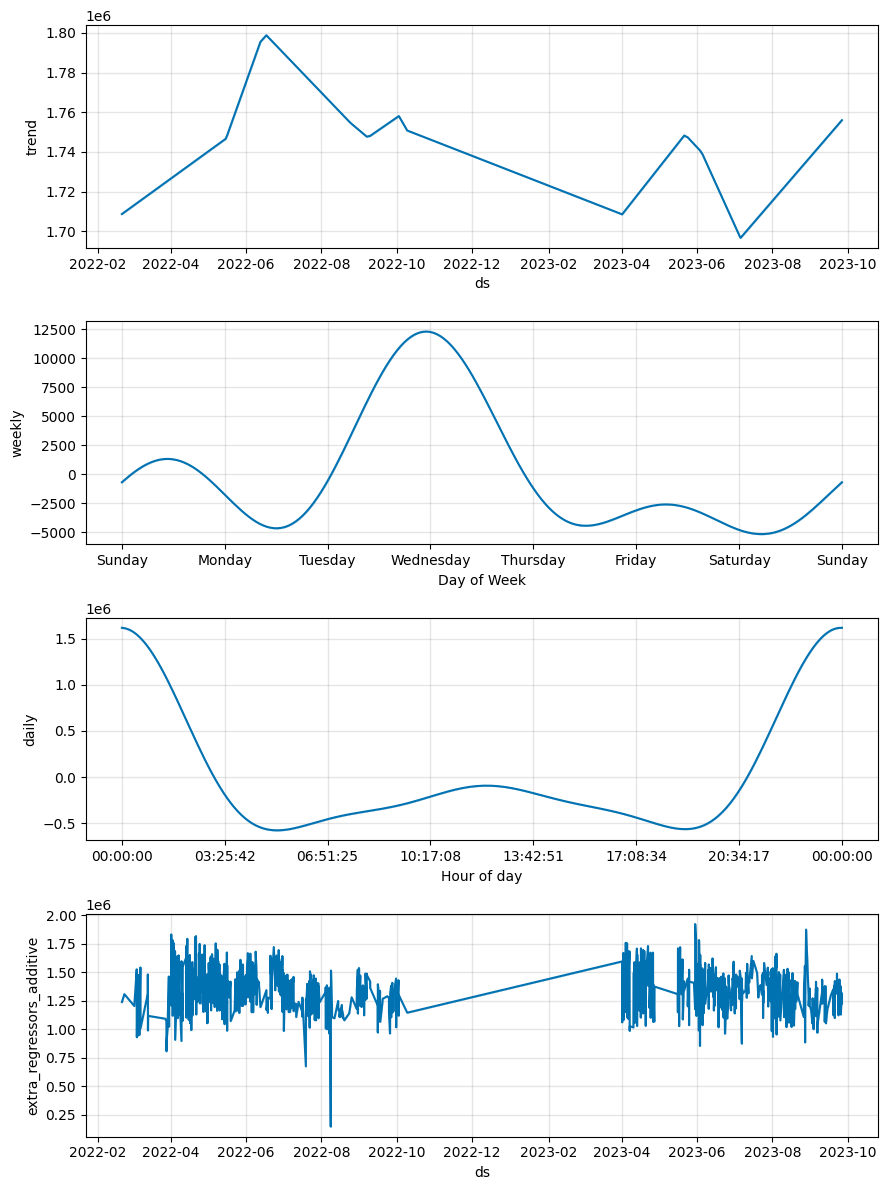

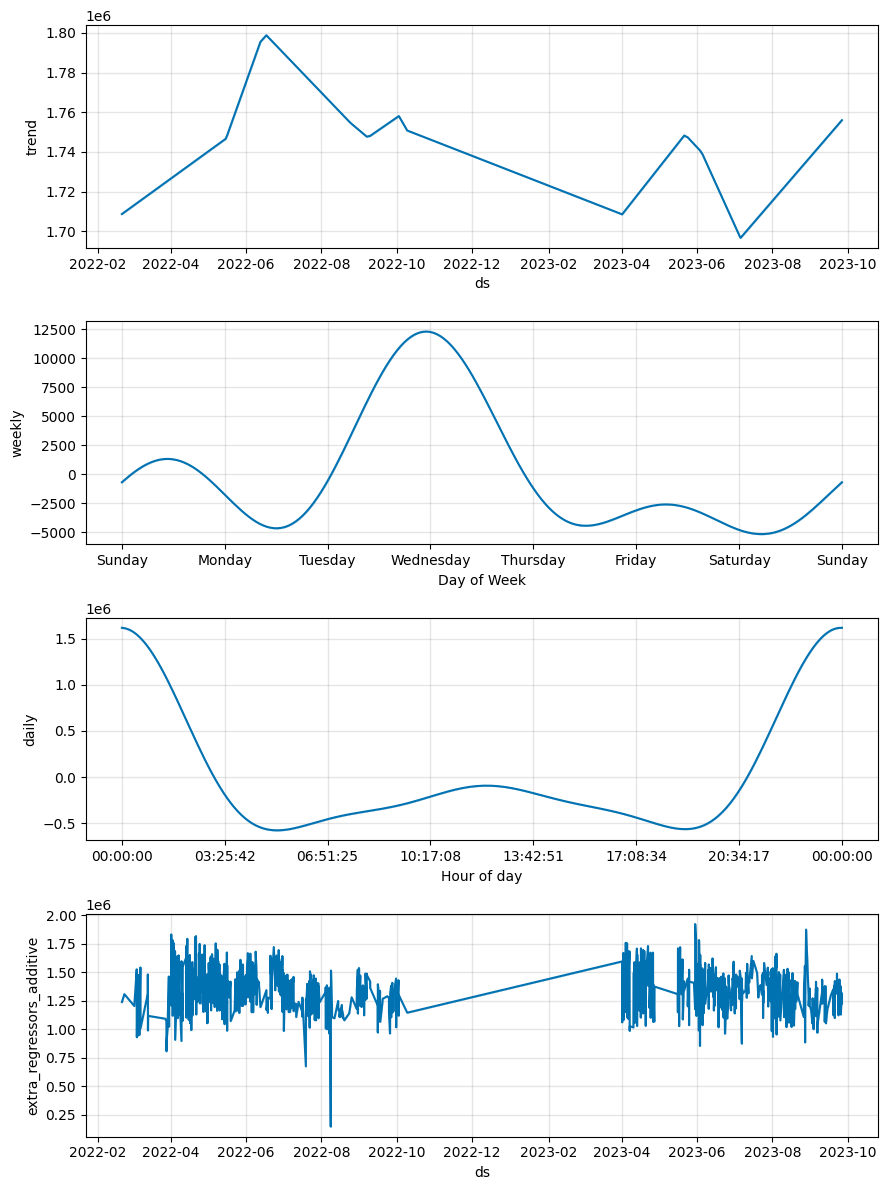

In [70]:
model.plot_components(model.predict(test_df))